In [ ]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import os
if not os.path.exists('plots/'):
    os.mkdir('plots')

from six.moves import cPickle
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import numpy as np
import tf_keras.backend as K

import kde
import simplebinmi
import matrixRenyi

import utils

# Which measure to plot
infoplane_measure = 'upper'
# infoplane_measure = 'bin'
# infoplane_measure = 'matrix'

# Max number of epoch for which to compute mutual information measure
MAX_EPOCHS = 2001
COLORBAR_MAX_EPOCHS = 2001
# MAX_EPOCHS = 10001
# COLORBAR_MAX_EPOCHS = 10001

# Directories from which to load saved layer activity
ARCH = '512-256-128-64-32-16-10-10'
# ARCH = '10-10-10-10'
# ARCH = '10-8-6-4-2'
activation = 'tanh'

In [ ]:
# import the MI values
def get_MI_values(ARCH):
    """
    load calculated MIs in MNIST_ComputeMI file
    return a dictionary
    """
    with open(f"MIs/{ARCH}_MIs.pickle", "rb") as f:
        loaded_dict = pickle.load(f)
    return loaded_dict

def get_acc(ARCH):
    # print(f"MIs/{ARCH}MIs.pickle")
    SAVE_DIR = 'rawdata/' + "tanh_"+ ARCH
    with open(f"{SAVE_DIR}/losses.pickle", "rb") as f:
        acc = pickle.load(f)
    val_acc = acc['val_accuracy']
    acc = acc['accuracy']
    return val_acc, acc

### Relationship among model performance, $I(X; T)$, and $I(Y; T)$ (Figure 5.10, 5.11)

In [ ]:
ARCH =  '512-256-128-64-32-16-10-10'
dict = get_MI_values(ARCH)
val_acc, acc  = get_acc(ARCH)

infoplane_measure = 'upper'
PLOT_LAYERS = [0]
fig=plt.figure(figsize=(12,10))
# for measures in [loaded_dict_10, loaded_dict_1024]:
COLORBAR_MAX_EPOCHS = 10001
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS))
sm._A = []

for actndx, (activation, vals) in enumerate(dict.items()):
    epochs = sorted(vals.keys())
    if not len(epochs):
        continue
    # plt.subplot(1,2,actndx+1)   
    for epoch in epochs:
        c = sm.to_rgba(epoch)
        # Plot the I(X; T)
        xmvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[-1]
        ymvals = np.array(val_acc[epoch]) 
        plt.xlabel('I(X; T)',fontsize=40)
        plt.ylabel('Predicting Accuracy',fontsize=40)

        # Plot the I(Y; T)
        # xmvals = np.array(vals[epoch]['MI_YM_'+infoplane_measure])[-1]
        # ymvals = np.array(acc[epoch]) 
        # plt.xlabel('I(Y; T)',fontsize=40)
        # plt.ylabel('Training Accuracy',fontsize=40)
        
        # plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
        plt.scatter(xmvals, ymvals, s=50, facecolors=[c for _ in PLOT_LAYERS], edgecolor='None', zorder=2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)    
    
cbaxes = fig.add_axes([1.0, 0.125, 0.03, 0.8]) 
plt.colorbar(sm, label='Epoch', cax=cbaxes)
plt.tight_layout()

DO_SAVE = False
if DO_SAVE:
    plt.savefig('plots/' + 'correlation_I(X;T)_' + ARCH,bbox_inches='tight')
    # plt.savefig('plots/' + DIR_TEMPLATE % ('infoplane_'+ARCH), bbox_inches='tight')

### The information plane of final output layers (Figure 5.13)

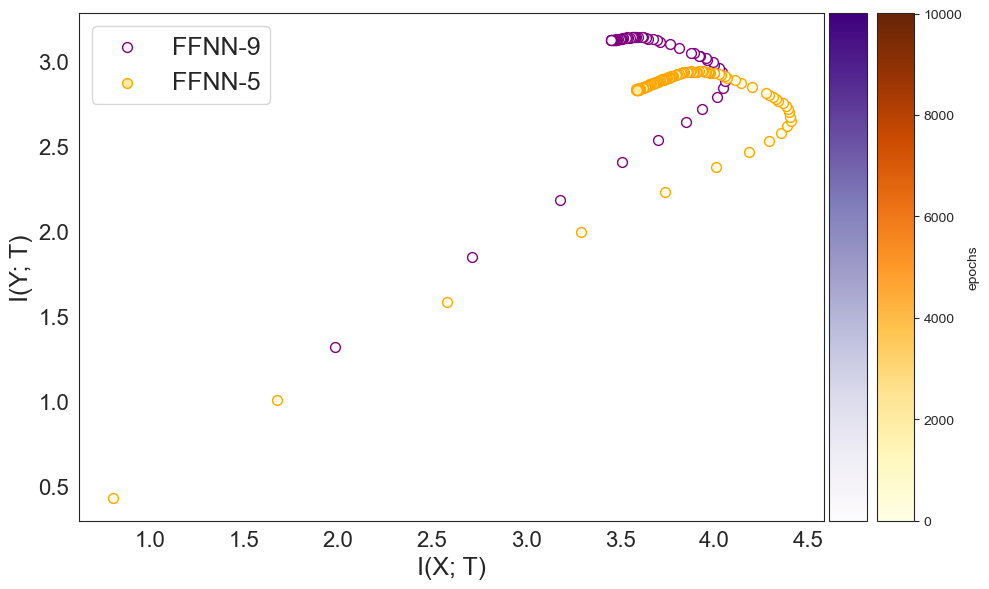

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

ARCH2 = '10-10-10-10'
dict = get_MI_values(ARCH)
dict_2 = get_MI_values(ARCH2)

# Create ScalarMappable instances for each scatter plot
norm1 = plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS)
cmap1 = cm.Purples
sm1 = cm.ScalarMappable(cmap=cmap1, norm=norm1)
sm1.set_array([])

norm2 = plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS)
cmap2 = cm.YlOrBr
sm2 = cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])


infoplane_measure = 'upper'
# Create the main plot with two scatter plots
fig, ax = plt.subplots(figsize=(10, 6))

plt.xlabel('I(X; T)',fontsize=18)
# plt.ylabel('Predicting Accuracy',fontsize=20)
plt.ylabel('I(Y; T)',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 
# First scatter plot
for actndx, (activation, vals) in enumerate(dict.items()):
    epochs = sorted(vals.keys())
    if not len(epochs):
        continue
    for epoch in epochs:
        c = sm1.to_rgba(epoch)
        xmvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[-1]
        ymvals = np.array(vals[epoch]['MI_YM_'+infoplane_measure])[-1]
        # ymvals = np.array(acc[epoch])
        ax.scatter(xmvals, ymvals, s=50, facecolors=[c for _ in PLOT_LAYERS], edgecolor='purple', zorder=2)

    ax.scatter(xmvals, ymvals, s=50, facecolors=[c for _ in PLOT_LAYERS], edgecolor='purple', zorder=2, label="FFNN-9")
               # label="Mean accuracy: 93%")
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    cbar1 = plt.colorbar(sm1, cax=cax1)
    cax1.yaxis.set_ticks([])  # Remove ticks

# Second scatter plot
for actndx, (activation, vals) in enumerate(dict_2.items()):
    epochs = sorted(vals.keys())
    if not len(epochs):
        continue
    for epoch in epochs:
        c = sm2.to_rgba(epoch)
        xmvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[-1]
        ymvals = np.array(vals[epoch]['MI_YM_'+infoplane_measure])[-1]
        
        # ymvals = np.array(acc[epoch])
        # plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
        ax.scatter(xmvals, ymvals, s=50, facecolors=[c for _ in PLOT_LAYERS], edgecolor='orange', zorder=2)
    ax.scatter(xmvals, ymvals, s=50, facecolors=[c for _ in PLOT_LAYERS], edgecolor='orange', zorder=2, label="FFNN-5")

    cax2 = divider.append_axes("right", size="5%", pad=0.1)  # pad determines the distance between colorbars
    cbar2 = plt.colorbar(sm2, cax=cax2, orientation='vertical', label='epochs')
    cbar2.set_label('epochs')
    cax2.yaxis.set_ticks_position('right')  # Make ticks appear on the left side

# ax.set_xlabel('I(X; T)',fontsize=20)
# ax.set_ylabel('y/z values')
# ax.set_title('Two Scatter Plots with Colorbars')
# ax.grid(True)
ax.legend(fontsize=18)
 
plt.tight_layout()
# plt.show()


DO_SAVE = False
if DO_SAVE:
    plt.savefig('plots/' + 'FFNN-5_output_layer_infoplane' ,bbox_inches='tight')


### Data processing inequality (Figure 5.7)

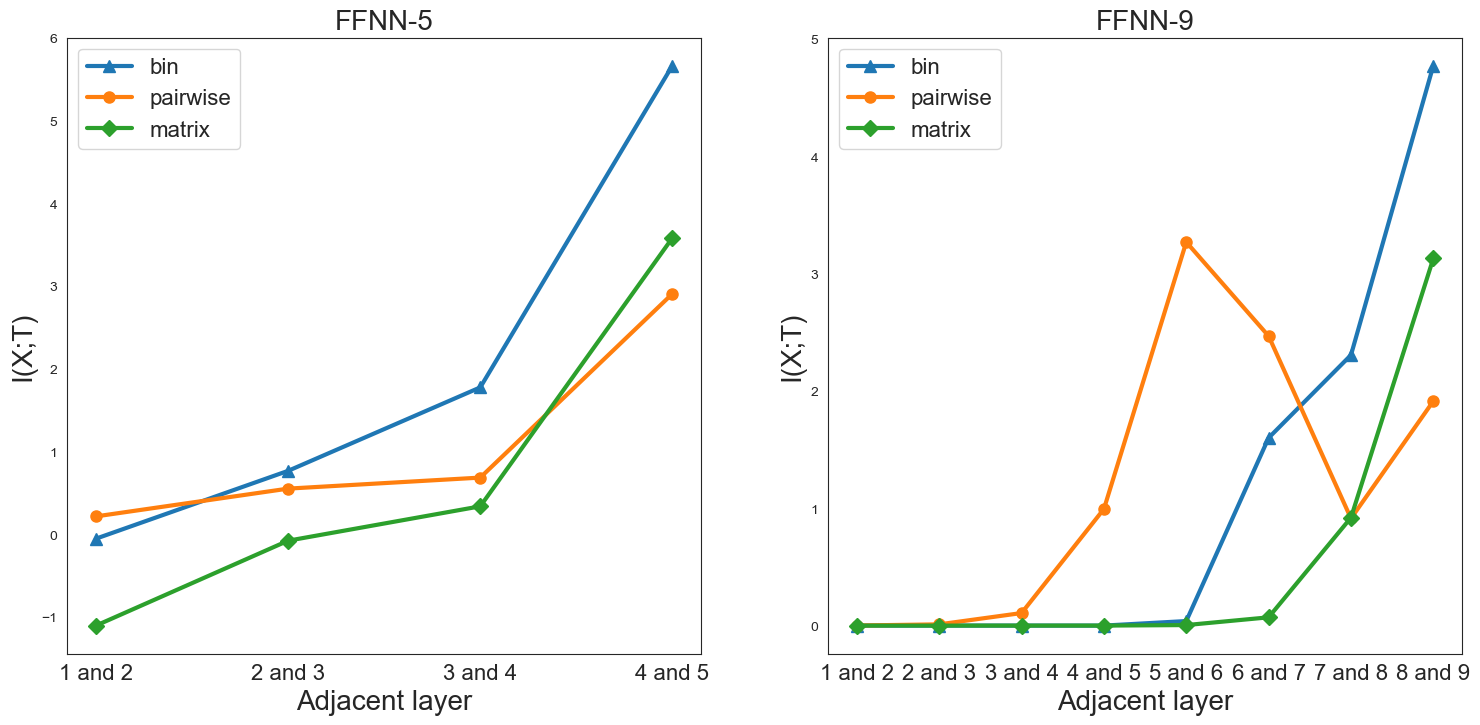

In [32]:
sns.set_style('white')
fig, ax = plt.subplots(1,2, figsize=(18,8)) 
markers = {'bin':'^', 'upper':'o', 'matrix':'D'}
ARCH = ["10-10-10-10", '512-256-128-64-32-16-10-10']
for i in range(len(ARCH)):

    with open(f"MIs/{ARCH[i]}_MIs.pickle", "rb") as f:
        loaded_dict = pickle.load(f)
    MIs = loaded_dict['tanh']
    
    # moving_diff = np.zeros(len(MIs[0]['MI_XM_upper'])-1)
    
    for infoplane in ['bin', 'upper', 'matrix']:
        moving_diff = np.zeros(len(MIs[0]['MI_XM_'+ infoplane])-1)
        for epoch in MIs.keys():

            x = np.array(MIs[epoch]['MI_XM_'+infoplane])
            # print(x.shape)
            
            diff = [x[i] - x[i + 1] for i in range(0, len(x)-1)]
            moving_diff = np.add(moving_diff, diff)
            # moving_diff = np.add(moving_diff, np.diff(x))
        ax[i].plot((moving_diff)/len(MIs.keys()),marker=markers[infoplane], label=infoplane,lw=3, markersize=8)
        ax[i].set_ylabel('I(X;T)', fontsize=20)
        ax[i].set_xticks([])

        x_tick_locations = list(range(len(moving_diff)))
        x_tick_labels = [f'{i+1} and {i+2}' for i in range(len(moving_diff))]
        ax[i].set_xticks(x_tick_locations)

        ax[i].set_xticklabels(x_tick_labels, fontsize=16)
        if i==0:
            ax[i].set_title('FFNN-5', fontsize=20)
        else:
            ax[i].set_title('FFNN-9', fontsize=20)
        ax[i].set_xlabel("Adjacent layer", fontsize=20)
        ax[i].legend(["bin", "pairwise", "matrix"] , fontsize=16)
        # ax[i].legend()
DO_SAVE = False
if DO_SAVE:
    fig.savefig('plots/' + ("Mean diff of adjacent layers"),bbox_inches='tight')

### Average $I(X; T)$ in each layer (Figure 5.8)

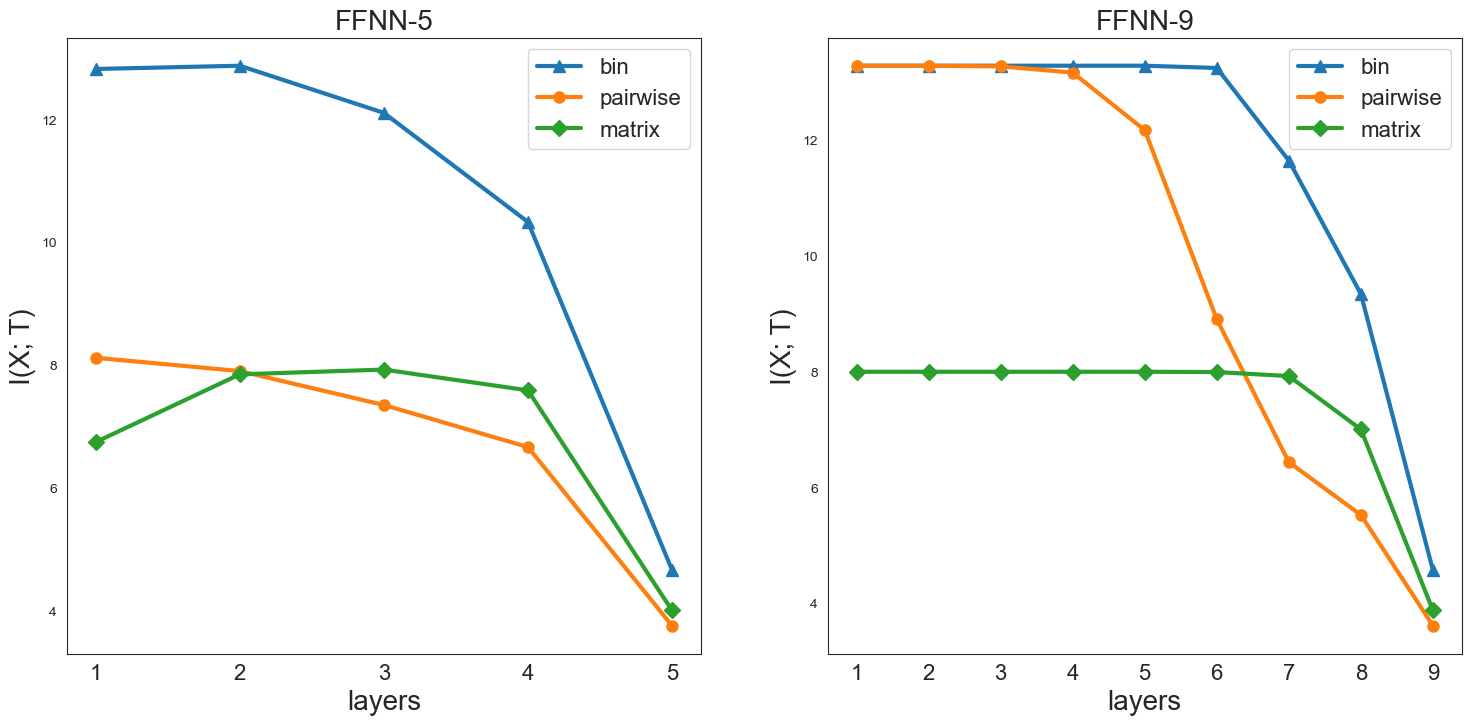

In [31]:
fig, ax = plt.subplots(1,2, figsize=(18,8)) 
markers = {'bin':'^', 'upper':'o', 'matrix':'D'}
ARCH = ["10-10-10-10", '512-256-128-64-32-16-10-10']
for i in range(len(ARCH)):

    with open(f"MIs/{ARCH[i]}_MIs.pickle", "rb") as f:
        loaded_dict = pickle.load(f)
    MIs = loaded_dict['tanh']
    
    moving_diff = np.zeros(len(MIs[0]['MI_XM_upper'])-1)

    for infoplane in ['bin', 'upper', 'matrix']:
    # for infoplane in ['upper']:

        avg_mi = np.zeros(len(MIs[0]['MI_XM_'+ infoplane]))
        X =  np.zeros(len(MIs[0]['MI_XM_'+ infoplane]))
        for epoch in MIs.keys():
            if infoplane == 'upper':
                x = np.array(MIs[epoch]['MI_XM_'+infoplane])
            else:   
                x = np.array(MIs[epoch]['MI_XM_'+infoplane])
                # print(x, X)
            X = np.add(X, x)
        
        avg_mi = X/len(MIs.keys())
        ax[i].plot(avg_mi,marker=markers[infoplane],label=infoplane, lw=3, markersize=8)
        ax[i].set_ylabel('I(X; T)', fontsize=20)
        ax[i].set_xticks([])
        if i==0:
            ax[i].set_title('FFNN-5', fontsize=20)
        else:
            ax[i].set_title('FFNN-9', fontsize=20)
        x_tick_locations = list(range(len(moving_diff)+1))
        x_tick_labels = [f'{i}' for i in range(1, len(moving_diff)+2)]
        ax[i].set_xticks(x_tick_locations)

        ax[i].set_xticklabels(x_tick_labels, fontsize=16)
        
        ax[i].set_xlabel("layers", fontsize=20)
        ax[i].legend(["bin", "pairwise", "matrix"] , fontsize=16)
        # ax[i].legend()
DO_SAVE = False
if DO_SAVE:
    fig.savefig('plots/' + ("Mean diff in I(X; T)"),bbox_inches='tight')

### Infoplane in final layer (Figure 5.9)

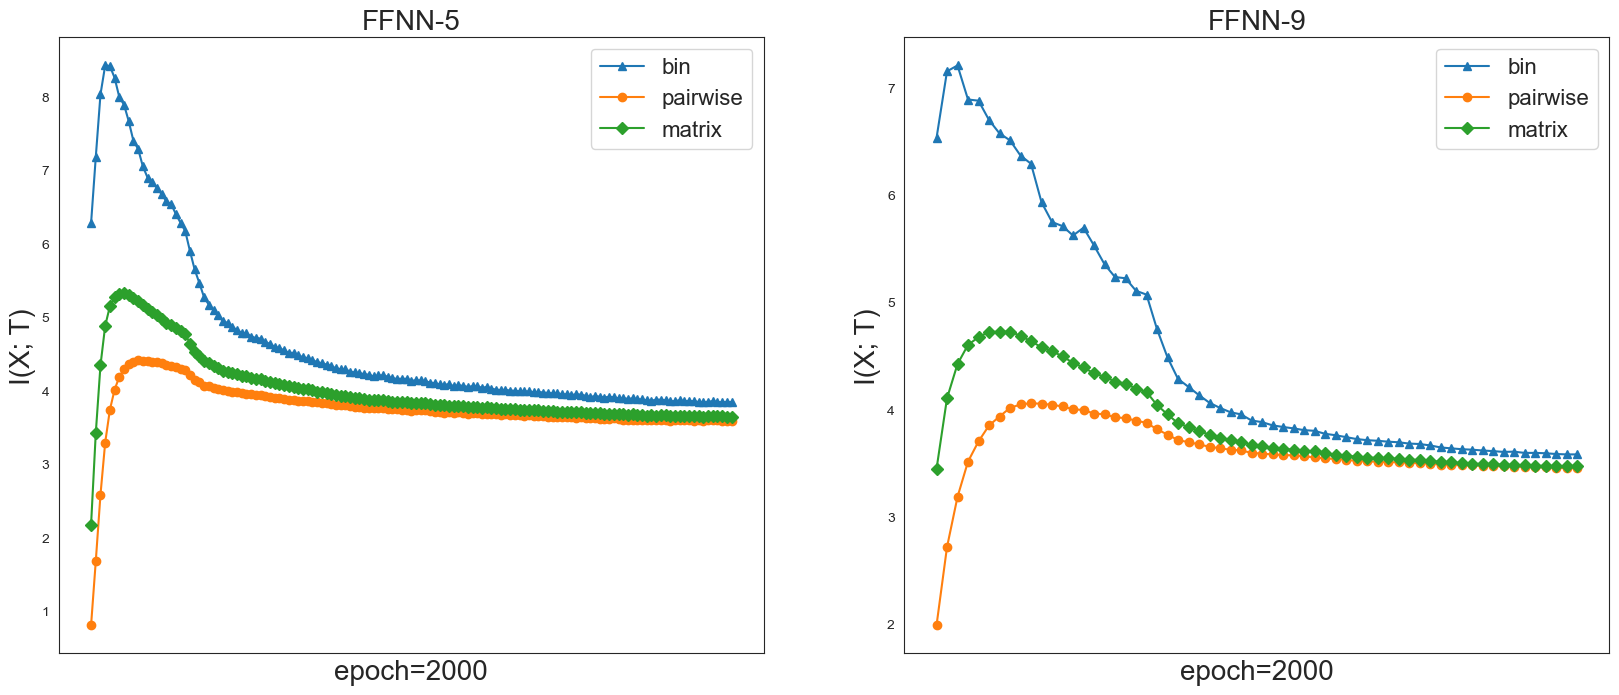

In [30]:
fig, ax = plt.subplots(1,2, figsize=(20,8)) 
markers = {'bin':'^', 'upper':'o', 'matrix':'D'}
ARCH = ["10-10-10-10", '512-256-128-64-32-16-10-10']
for i in range(len(ARCH)):

    with open(f"MIs/{ARCH[i]}_MIs.pickle", "rb") as f:
        loaded_dict = pickle.load(f)
    MIs = loaded_dict['tanh']
    
    

    for infoplane in ['bin', 'upper', 'matrix']:
    # for infoplane in ['upper']:
        values = np.zeros(len(MIs.keys()))
        # avg_mi = np.zeros(len(MIs[0]['MI_XM_'+ infoplane]))
        l =0
        for epoch in MIs.keys():
            
            x = np.array(MIs[epoch]['MI_XM_'+infoplane][-1])
            # x = np.array(MIs[epoch]['MI_YM_'+infoplane][-1])
            values[l] = np.mean(x)
            l+=1
        ax[i].plot(values,marker=markers[infoplane], label=infoplane)
        ax[i].set_ylabel('I(X; T)', fontsize=20)
        # ax[i].set_ylabel('I(Y; T)', fontsize=20)
        ax[i].set_xticks([])

        if i==0:
            ax[i].set_title('FFNN-5', fontsize=20)
        else:
            ax[i].set_title('FFNN-9', fontsize=20)
        
        ax[i].set_xlabel("epoch=2000", fontsize=20)
        ax[i].legend(["bin", "pairwise", "matrix"] , fontsize=16)
        # ax[i].legend()
DO_SAVE = False
if DO_SAVE:
    fig.savefig('plots/' + ("output I(Y; T) by epochs"),bbox_inches='tight')

### Binning-based estimation with various bin sizes (Figure 5.1)

In [ ]:
# Save the MI values in MNIST/SZT_ComputeMI.ipynb first
MI_XM = {}
ARCH = '512-256-128-64-32-16-10-10'
measures = get_MI_values(ARCH)
binsize = 0.1

layer1_MX= []
layer2_MX= []
layer3_MX= []
layer4_MX= []
layer5_MX= []
layer6_MX= []
layer7_MX= []
layer8_MX= []
layer9_MX= []

L = [
layer1_MX,
layer2_MX,
layer3_MX,
layer4_MX,
layer5_MX,
layer6_MX,
layer7_MX,
layer8_MX,
layer9_MX
]


MI_XM[binsize] = L
activation = 'tanh'
MI = "MI_HM_bin"

for epoch in measures[activation].keys():
    L[0] .append(measures[activation][epoch][MI][0])
    L[1] .append(measures[activation][epoch][MI][1])
    L[2] .append(measures[activation][epoch][MI][2])
    L[3] .append(measures[activation][epoch][MI][3])
    L[4] .append(measures[activation][epoch][MI][4])
    L[5] .append(measures[activation][epoch][MI][5])
    L[6] .append(measures[activation][epoch][MI][6])
    L[7] .append(measures[activation][epoch][MI][7])
    L[8] .append(measures[activation][epoch][MI][8])

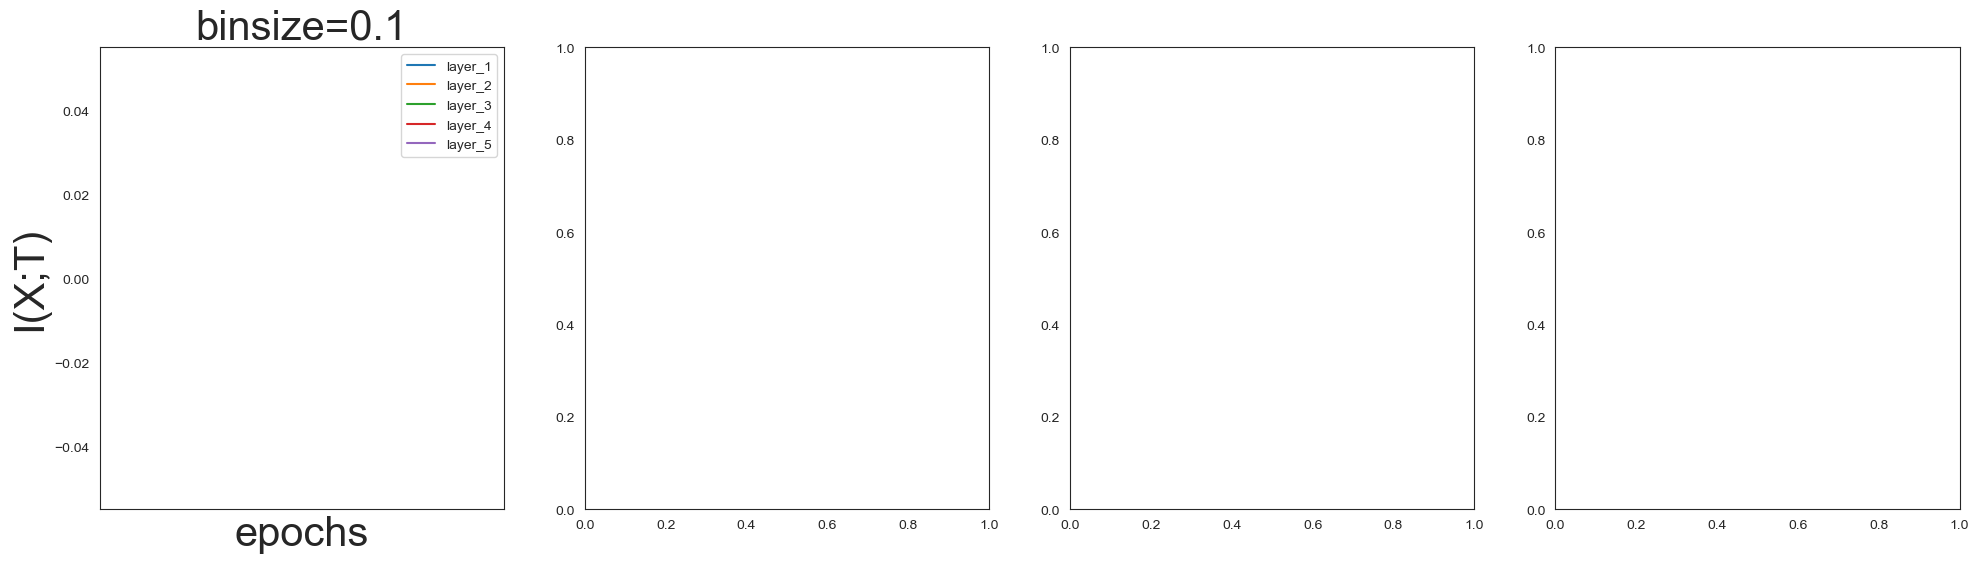

In [34]:
fig, axs = plt.subplots(1, 4, figsize =(24,6)) 
idx = 0
for key in sorted(MI_XM.keys()):
    L = MI_XM[key]
    for l in range(len(L)-4):
        axs[idx].plot(L[l], label=f"layer_{l+1}")
            # Set title and legend for each subplot
        axs[idx].set_title(f"binsize={key}", fontsize=30)
        axs[idx].set_xticks([])

        axs[idx].grid(False)
        
        if idx == 0:
            axs[idx].legend()
            axs[idx].set_ylabel("I(X;T)", fontsize=30)
            axs[idx].set_xlabel("epochs", fontsize=30)
    idx+=1
plt.show()
DO_SAVE = False
if DO_SAVE:
    fig.savefig('plots/binsize_'+ARCH+'_'+"tanh"+"_"+infoplane_measure, bbox_inches='tight')